### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Thu Feb 20 08:19:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [3]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 86.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [4]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-02-20 08:22:08--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-02-20 08:22:08 (88.6 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


100%|██████████| 51.2M/51.2M [00:01<00:00, 35.7MB/s]


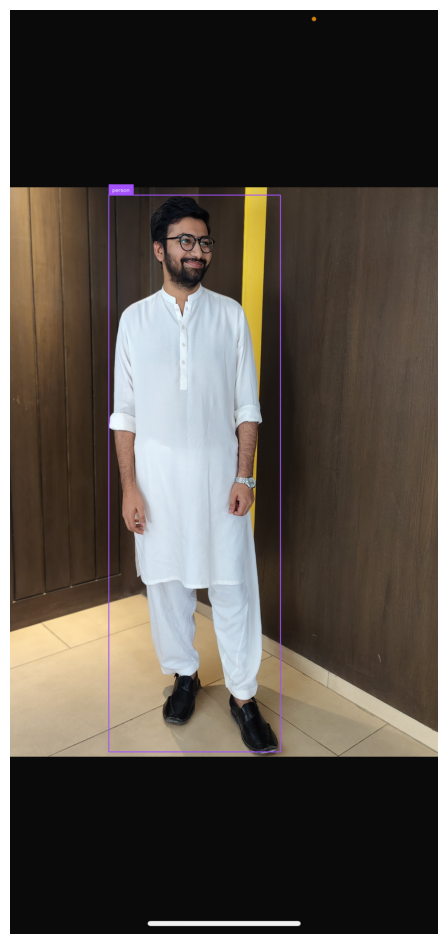

In [5]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/xcBYLI.png"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [6]:


!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="NqjtCN1BkDxTg2u1jXzs")
project = rf.workspace("augmented-startups").project("weeds-nxe1w")
version = project.version(3)
dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Weeds-3 in yolov11:: 100%|██████████| 8418/8418 [00:01<00:00, 4293.90it/s]


In [7]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [8]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [9]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['Weeds']

roboflow:
  workspace: augmented-startups
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [10]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=100)

New https://pypi.org/project/ultralytics/8.3.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/Weeds-3/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fra

100%|██████████| 755k/755k [00:00<00:00, 103MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    689920  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.34M/5.34M [00:00<00:00, 248MB/s]


AMP: checks passed ✅


train: Scanning /content/Weeds-3/train/labels... 3664 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3664/3664 [00:01<00:00, 2226.71it/s]

train: New cache created: /content/Weeds-3/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/Weeds-3/valid/labels... 359 images, 0 backgrounds, 0 corrupt: 100%|██████████| 359/359 [00:00<00:00, 838.05it/s]


val: New cache created: /content/Weeds-3/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/229 [00:00<?, ?it/s]Memory Efficient attention defaults to a non-deterministic algorithm. To explicitly enable determinism call torch.use_deterministic_algorithms(True, warn_only=False). (Triggered internally at ../aten/src/ATen/native/transformers/cuda/attention_backward.cu:655.)
      1/100      5.28G       2.96      3.245      3.635         99        640: 100%|██████████| 229/229 [01:40<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.09it/s]

                   all        359        920      0.151      0.157     0.0718     0.0235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       5.2G       2.27      2.412      2.755         63        640: 100%|██████████| 229/229 [01:35<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

                   all        359        920      0.475      0.451      0.431      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.21G      2.015      2.109      2.453         89        640: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.52it/s]


                   all        359        920      0.538      0.483        0.5      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       5.2G      1.884      1.955       2.27         87        640: 100%|██████████| 229/229 [01:32<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.80it/s]

                   all        359        920       0.63      0.482      0.553      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.23G      1.811      1.827      2.169         66        640: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.37it/s]

                   all        359        920      0.586      0.587      0.624      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.21G       1.75       1.75      2.089         67        640: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.81it/s]

                   all        359        920      0.689       0.61      0.683      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       5.2G        1.7      1.671      2.033         61        640: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.83it/s]

                   all        359        920      0.737      0.623      0.707      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.19G      1.636      1.584      1.973         94        640: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.54it/s]

                   all        359        920      0.718      0.634      0.722      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.24G       1.61      1.538      1.946         68        640: 100%|██████████| 229/229 [01:32<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.88it/s]

                   all        359        920      0.766      0.674      0.771       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.23G       1.58      1.491      1.902         72        640: 100%|██████████| 229/229 [01:32<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.44it/s]

                   all        359        920      0.773      0.691      0.786      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       5.2G      1.543       1.44      1.874         59        640: 100%|██████████| 229/229 [01:38<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.48it/s]

                   all        359        920       0.83      0.699      0.813      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.18G      1.534      1.405      1.857        103        640: 100%|██████████| 229/229 [01:33<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


                   all        359        920      0.873       0.69      0.821      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.21G      1.505      1.366      1.825         81        640: 100%|██████████| 229/229 [01:32<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.87it/s]

                   all        359        920      0.827      0.749      0.836      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.21G      1.483      1.328      1.791         43        640: 100%|██████████| 229/229 [01:32<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.50it/s]


                   all        359        920      0.781      0.777      0.839      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.21G      1.462      1.291      1.776         68        640: 100%|██████████| 229/229 [01:31<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.89it/s]

                   all        359        920      0.815      0.772      0.859      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.24G       1.46      1.282      1.777        105        640: 100%|██████████| 229/229 [01:31<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.51it/s]

                   all        359        920      0.831      0.704      0.826      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.23G      1.425      1.244      1.748         72        640: 100%|██████████| 229/229 [01:31<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.87it/s]

                   all        359        920      0.849      0.735      0.845      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.21G      1.422      1.238      1.739         56        640: 100%|██████████| 229/229 [01:31<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.52it/s]

                   all        359        920      0.901       0.73      0.866      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.21G        1.4      1.198      1.702         78        640: 100%|██████████| 229/229 [01:32<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.86it/s]

                   all        359        920      0.873      0.763      0.875      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.22G      1.386      1.165      1.688         73        640: 100%|██████████| 229/229 [01:32<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.86it/s]

                   all        359        920      0.893      0.764      0.884      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.21G      1.368      1.148      1.677         74        640: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.52it/s]

                   all        359        920      0.885      0.775      0.875       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.21G      1.361       1.13      1.669         57        640: 100%|██████████| 229/229 [01:32<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.83it/s]

                   all        359        920      0.869      0.785      0.869       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100       5.2G      1.355      1.133      1.666         92        640: 100%|██████████| 229/229 [01:32<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.42it/s]

                   all        359        920      0.866      0.787      0.885      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.19G      1.323      1.081      1.634         76        640: 100%|██████████| 229/229 [01:31<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.85it/s]

                   all        359        920      0.864      0.828        0.9      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.23G      1.319      1.075       1.63         86        640: 100%|██████████| 229/229 [01:31<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.63it/s]

                   all        359        920      0.899      0.803      0.904      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.21G      1.304      1.055      1.615        114        640: 100%|██████████| 229/229 [01:31<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.90it/s]

                   all        359        920      0.912      0.786      0.901      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.23G       1.29      1.041      1.599         97        640: 100%|██████████| 229/229 [01:32<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.84it/s]

                   all        359        920      0.859      0.868      0.913      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       5.2G      1.287       1.03      1.583         77        640: 100%|██████████| 229/229 [01:32<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.52it/s]

                   all        359        920      0.855      0.803      0.884      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.25G      1.262      1.002       1.57         74        640: 100%|██████████| 229/229 [01:32<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.89it/s]

                   all        359        920      0.926      0.846      0.925      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.21G      1.257     0.9859      1.563         92        640: 100%|██████████| 229/229 [01:31<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.59it/s]

                   all        359        920      0.888      0.819      0.902      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.18G      1.257      1.004      1.569         66        640: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.86it/s]

                   all        359        920      0.885      0.865      0.933      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.22G       1.23     0.9637      1.541         68        640: 100%|██████████| 229/229 [01:31<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.53it/s]

                   all        359        920      0.876      0.853      0.927      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       5.2G      1.221     0.9601      1.526        111        640: 100%|██████████| 229/229 [01:30<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.91it/s]

                   all        359        920      0.899      0.876      0.938      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.21G      1.207      0.949      1.524         92        640: 100%|██████████| 229/229 [01:31<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.53it/s]

                   all        359        920      0.908      0.853      0.937      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.23G      1.196     0.9338      1.514         90        640: 100%|██████████| 229/229 [01:31<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.89it/s]

                   all        359        920      0.911      0.865      0.937      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.19G      1.201     0.9206      1.501         55        640: 100%|██████████| 229/229 [01:31<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.54it/s]

                   all        359        920      0.913      0.861      0.943      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.26G       1.18     0.9147      1.497         62        640: 100%|██████████| 229/229 [01:31<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.90it/s]

                   all        359        920      0.888        0.9      0.951      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.23G      1.162     0.8862      1.478         61        640: 100%|██████████| 229/229 [01:31<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.49it/s]

                   all        359        920        0.9      0.873      0.933       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.23G       1.16     0.8887      1.473         93        640: 100%|██████████| 229/229 [01:31<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.93it/s]

                   all        359        920      0.893      0.885      0.943      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.19G      1.149     0.8744      1.466         52        640: 100%|██████████| 229/229 [01:31<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.51it/s]

                   all        359        920      0.896      0.896      0.948      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.21G      1.137     0.8602      1.451         64        640: 100%|██████████| 229/229 [01:31<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.89it/s]

                   all        359        920      0.907       0.89      0.952      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.21G      1.131     0.8548      1.449         98        640: 100%|██████████| 229/229 [01:31<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.51it/s]

                   all        359        920      0.921      0.867      0.947      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100       5.2G       1.12     0.8344      1.436         58        640: 100%|██████████| 229/229 [01:31<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.90it/s]

                   all        359        920      0.917      0.881       0.95      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.19G      1.121       0.84      1.445         78        640: 100%|██████████| 229/229 [01:31<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.54it/s]

                   all        359        920      0.895      0.898      0.948        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.21G      1.107     0.8337      1.428         50        640: 100%|██████████| 229/229 [01:31<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.90it/s]

                   all        359        920       0.91      0.892       0.95        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.21G      1.098     0.8071      1.421         65        640: 100%|██████████| 229/229 [01:30<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.48it/s]

                   all        359        920      0.892      0.911      0.954      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100       5.2G      1.096     0.8251       1.43         89        640: 100%|██████████| 229/229 [01:31<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.87it/s]

                   all        359        920        0.9      0.905       0.95       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.21G        1.1     0.8154      1.412        102        640: 100%|██████████| 229/229 [01:31<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.51it/s]

                   all        359        920       0.92      0.896      0.953      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.18G      1.086     0.8008      1.411         51        640: 100%|██████████| 229/229 [01:31<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.92it/s]

                   all        359        920      0.902      0.906      0.957      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.24G      1.078      0.789      1.398         63        640: 100%|██████████| 229/229 [01:31<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.44it/s]

                   all        359        920      0.892      0.925      0.955      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.21G      1.087     0.7846        1.4         86        640: 100%|██████████| 229/229 [01:31<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.90it/s]

                   all        359        920      0.921      0.904      0.957      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.19G      1.068     0.7783      1.391         89        640: 100%|██████████| 229/229 [01:31<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.49it/s]

                   all        359        920      0.901      0.914      0.956      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.23G      1.056     0.7686      1.381         76        640: 100%|██████████| 229/229 [01:31<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.90it/s]

                   all        359        920      0.911      0.919      0.959       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.21G      1.052     0.7708      1.378         80        640: 100%|██████████| 229/229 [01:31<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.53it/s]

                   all        359        920      0.912      0.921      0.958      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.23G      1.057     0.7543      1.379         72        640: 100%|██████████| 229/229 [01:31<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.82it/s]

                   all        359        920      0.907      0.922      0.961       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.22G      1.045     0.7592      1.377         72        640: 100%|██████████| 229/229 [01:33<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]

                   all        359        920      0.898      0.919      0.952      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.21G      1.033      0.743      1.364         72        640: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]

                   all        359        920      0.925      0.893      0.952      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       5.2G      1.029     0.7313       1.36         87        640: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.86it/s]

                   all        359        920      0.924      0.894      0.958      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100       5.2G      1.019     0.7326      1.349         67        640: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.51it/s]

                   all        359        920      0.912      0.924      0.961      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.21G      1.017     0.7223      1.353         77        640: 100%|██████████| 229/229 [01:32<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.87it/s]

                   all        359        920      0.895      0.932      0.961      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.23G      1.022     0.7173      1.346         74        640: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.48it/s]

                   all        359        920      0.911       0.93      0.963      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.23G      1.014     0.7146      1.345         50        640: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.85it/s]

                   all        359        920       0.91      0.928      0.959      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.23G      1.016     0.7207      1.345         72        640: 100%|██████████| 229/229 [01:33<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.79it/s]

                   all        359        920      0.919      0.911      0.962      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.19G      1.003     0.7041       1.33         65        640: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.54it/s]

                   all        359        920      0.903      0.938      0.964      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100       5.2G      1.002      0.702      1.338         78        640: 100%|██████████| 229/229 [01:31<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.88it/s]

                   all        359        920      0.908      0.928      0.961      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       5.2G     0.9955     0.7029      1.331         45        640: 100%|██████████| 229/229 [01:31<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.49it/s]

                   all        359        920      0.911      0.932      0.961      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.23G     0.9874     0.6881      1.327         77        640: 100%|██████████| 229/229 [01:31<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.91it/s]

                   all        359        920      0.908      0.939      0.963      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.19G     0.9856     0.6808       1.31         66        640: 100%|██████████| 229/229 [01:31<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.51it/s]

                   all        359        920       0.91      0.933      0.964      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.21G      0.984     0.6855      1.317         65        640: 100%|██████████| 229/229 [01:31<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.91it/s]

                   all        359        920      0.895      0.948      0.964      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.21G     0.9806     0.6808      1.316         52        640: 100%|██████████| 229/229 [01:31<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.56it/s]

                   all        359        920      0.931      0.919      0.965       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.21G     0.9755     0.6771      1.312         64        640: 100%|██████████| 229/229 [01:31<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.90it/s]

                   all        359        920      0.926      0.929      0.967      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.24G     0.9673     0.6684      1.309         67        640: 100%|██████████| 229/229 [01:31<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.50it/s]

                   all        359        920      0.914      0.943      0.969      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.23G      0.963     0.6681        1.3         62        640: 100%|██████████| 229/229 [01:31<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.90it/s]

                   all        359        920      0.911      0.939      0.969       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.23G     0.9601     0.6715      1.296         82        640: 100%|██████████| 229/229 [01:32<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.44it/s]

                   all        359        920      0.927       0.92      0.967      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.23G     0.9561     0.6611      1.294         68        640: 100%|██████████| 229/229 [01:32<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.91it/s]

                   all        359        920      0.896      0.957      0.972      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      5.19G     0.9507     0.6581      1.293         72        640: 100%|██████████| 229/229 [01:32<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.80it/s]

                   all        359        920      0.917      0.928      0.968      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100       5.2G     0.9362     0.6443      1.285         52        640: 100%|██████████| 229/229 [01:31<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.90it/s]

                   all        359        920      0.928      0.929      0.968      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.24G     0.9414     0.6455      1.289         67        640: 100%|██████████| 229/229 [01:31<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]

                   all        359        920      0.923      0.934      0.971      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.21G     0.9419     0.6501      1.287         60        640: 100%|██████████| 229/229 [01:32<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.80it/s]

                   all        359        920      0.921      0.943      0.971      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.19G     0.9267     0.6327       1.27         93        640: 100%|██████████| 229/229 [01:31<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.87it/s]

                   all        359        920      0.932      0.934      0.971      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.21G     0.9331     0.6322      1.271         80        640: 100%|██████████| 229/229 [01:31<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]

                   all        359        920      0.932      0.934      0.971      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.21G     0.9351      0.631      1.276         86        640: 100%|██████████| 229/229 [01:32<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.89it/s]

                   all        359        920       0.93      0.934      0.972      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.23G     0.9238     0.6309      1.267         81        640: 100%|██████████| 229/229 [01:32<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.50it/s]

                   all        359        920      0.923       0.94      0.971      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.19G     0.9135     0.6237      1.262         59        640: 100%|██████████| 229/229 [01:31<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.87it/s]

                   all        359        920      0.934      0.929       0.97      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.23G     0.9189     0.6278      1.269         77        640: 100%|██████████| 229/229 [01:31<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.47it/s]

                   all        359        920      0.923      0.941      0.973      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.21G     0.9059     0.6137      1.254         47        640: 100%|██████████| 229/229 [01:31<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.87it/s]

                   all        359        920      0.915       0.95      0.972      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100       5.2G     0.9012     0.6062      1.244         81        640: 100%|██████████| 229/229 [01:31<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.52it/s]

                   all        359        920      0.934      0.935      0.972      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100       5.2G     0.9017     0.6094      1.246         77        640: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.85it/s]

                   all        359        920      0.926      0.943      0.973      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.18G     0.9067     0.6143      1.253         72        640: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.58it/s]

                   all        359        920       0.92      0.948      0.972      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100       5.2G     0.8899     0.6049      1.243         68        640: 100%|██████████| 229/229 [01:31<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.88it/s]

                   all        359        920      0.925      0.949      0.972       0.77


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.23G     0.8528      0.487      1.215         33        640: 100%|██████████| 229/229 [01:31<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.61it/s]

                   all        359        920      0.936       0.94      0.973      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.17G     0.8214     0.4609      1.192         54        640: 100%|██████████| 229/229 [01:29<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.91it/s]

                   all        359        920      0.942      0.941      0.972      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.21G     0.8135     0.4535      1.186         35        640: 100%|██████████| 229/229 [01:30<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.55it/s]

                   all        359        920      0.938      0.934      0.972      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.21G     0.8156     0.4559      1.179         40        640: 100%|██████████| 229/229 [01:29<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.64it/s]

                   all        359        920      0.938      0.941      0.973      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.21G     0.7971     0.4393      1.169         22        640: 100%|██████████| 229/229 [01:29<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.89it/s]

                   all        359        920      0.937       0.94      0.971      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.19G     0.7951     0.4404      1.166         41        640: 100%|██████████| 229/229 [01:30<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.53it/s]

                   all        359        920      0.928      0.943      0.972      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.18G     0.7955     0.4399      1.168         33        640: 100%|██████████| 229/229 [01:30<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.88it/s]

                   all        359        920      0.938       0.94      0.972      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.18G     0.7907     0.4375      1.164         40        640: 100%|██████████| 229/229 [01:30<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.75it/s]

                   all        359        920      0.933      0.943      0.974      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100       5.2G     0.7905     0.4401      1.164         39        640: 100%|██████████| 229/229 [01:29<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]

                   all        359        920      0.932      0.942      0.972      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.17G     0.7872     0.4355      1.159         25        640: 100%|██████████| 229/229 [01:29<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.87it/s]

                   all        359        920      0.942      0.935      0.972      0.778



100 epochs completed in 2.718 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.9MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.9MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 352 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.70it/s]


                   all        359        920      0.934      0.943      0.974      0.779
Speed: 0.2ms preprocess, 6.9ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/train


## Evaluate fine-tuned YOLOv12 model

In [11]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					    R_curve.png		  val_batch0_labels.jpg
confusion_matrix_normalized.png			    results.csv		  val_batch0_pred.jpg
confusion_matrix.png				    results.png		  val_batch1_labels.jpg
events.out.tfevents.1740040071.422a93276c0f.2106.0  train_batch0.jpg	  val_batch1_pred.jpg
F1_curve.png					    train_batch1.jpg	  val_batch2_labels.jpg
labels_correlogram.jpg				    train_batch20610.jpg  val_batch2_pred.jpg
labels.jpg					    train_batch20611.jpg  weights
P_curve.png					    train_batch20612.jpg
PR_curve.png					    train_batch2.jpg


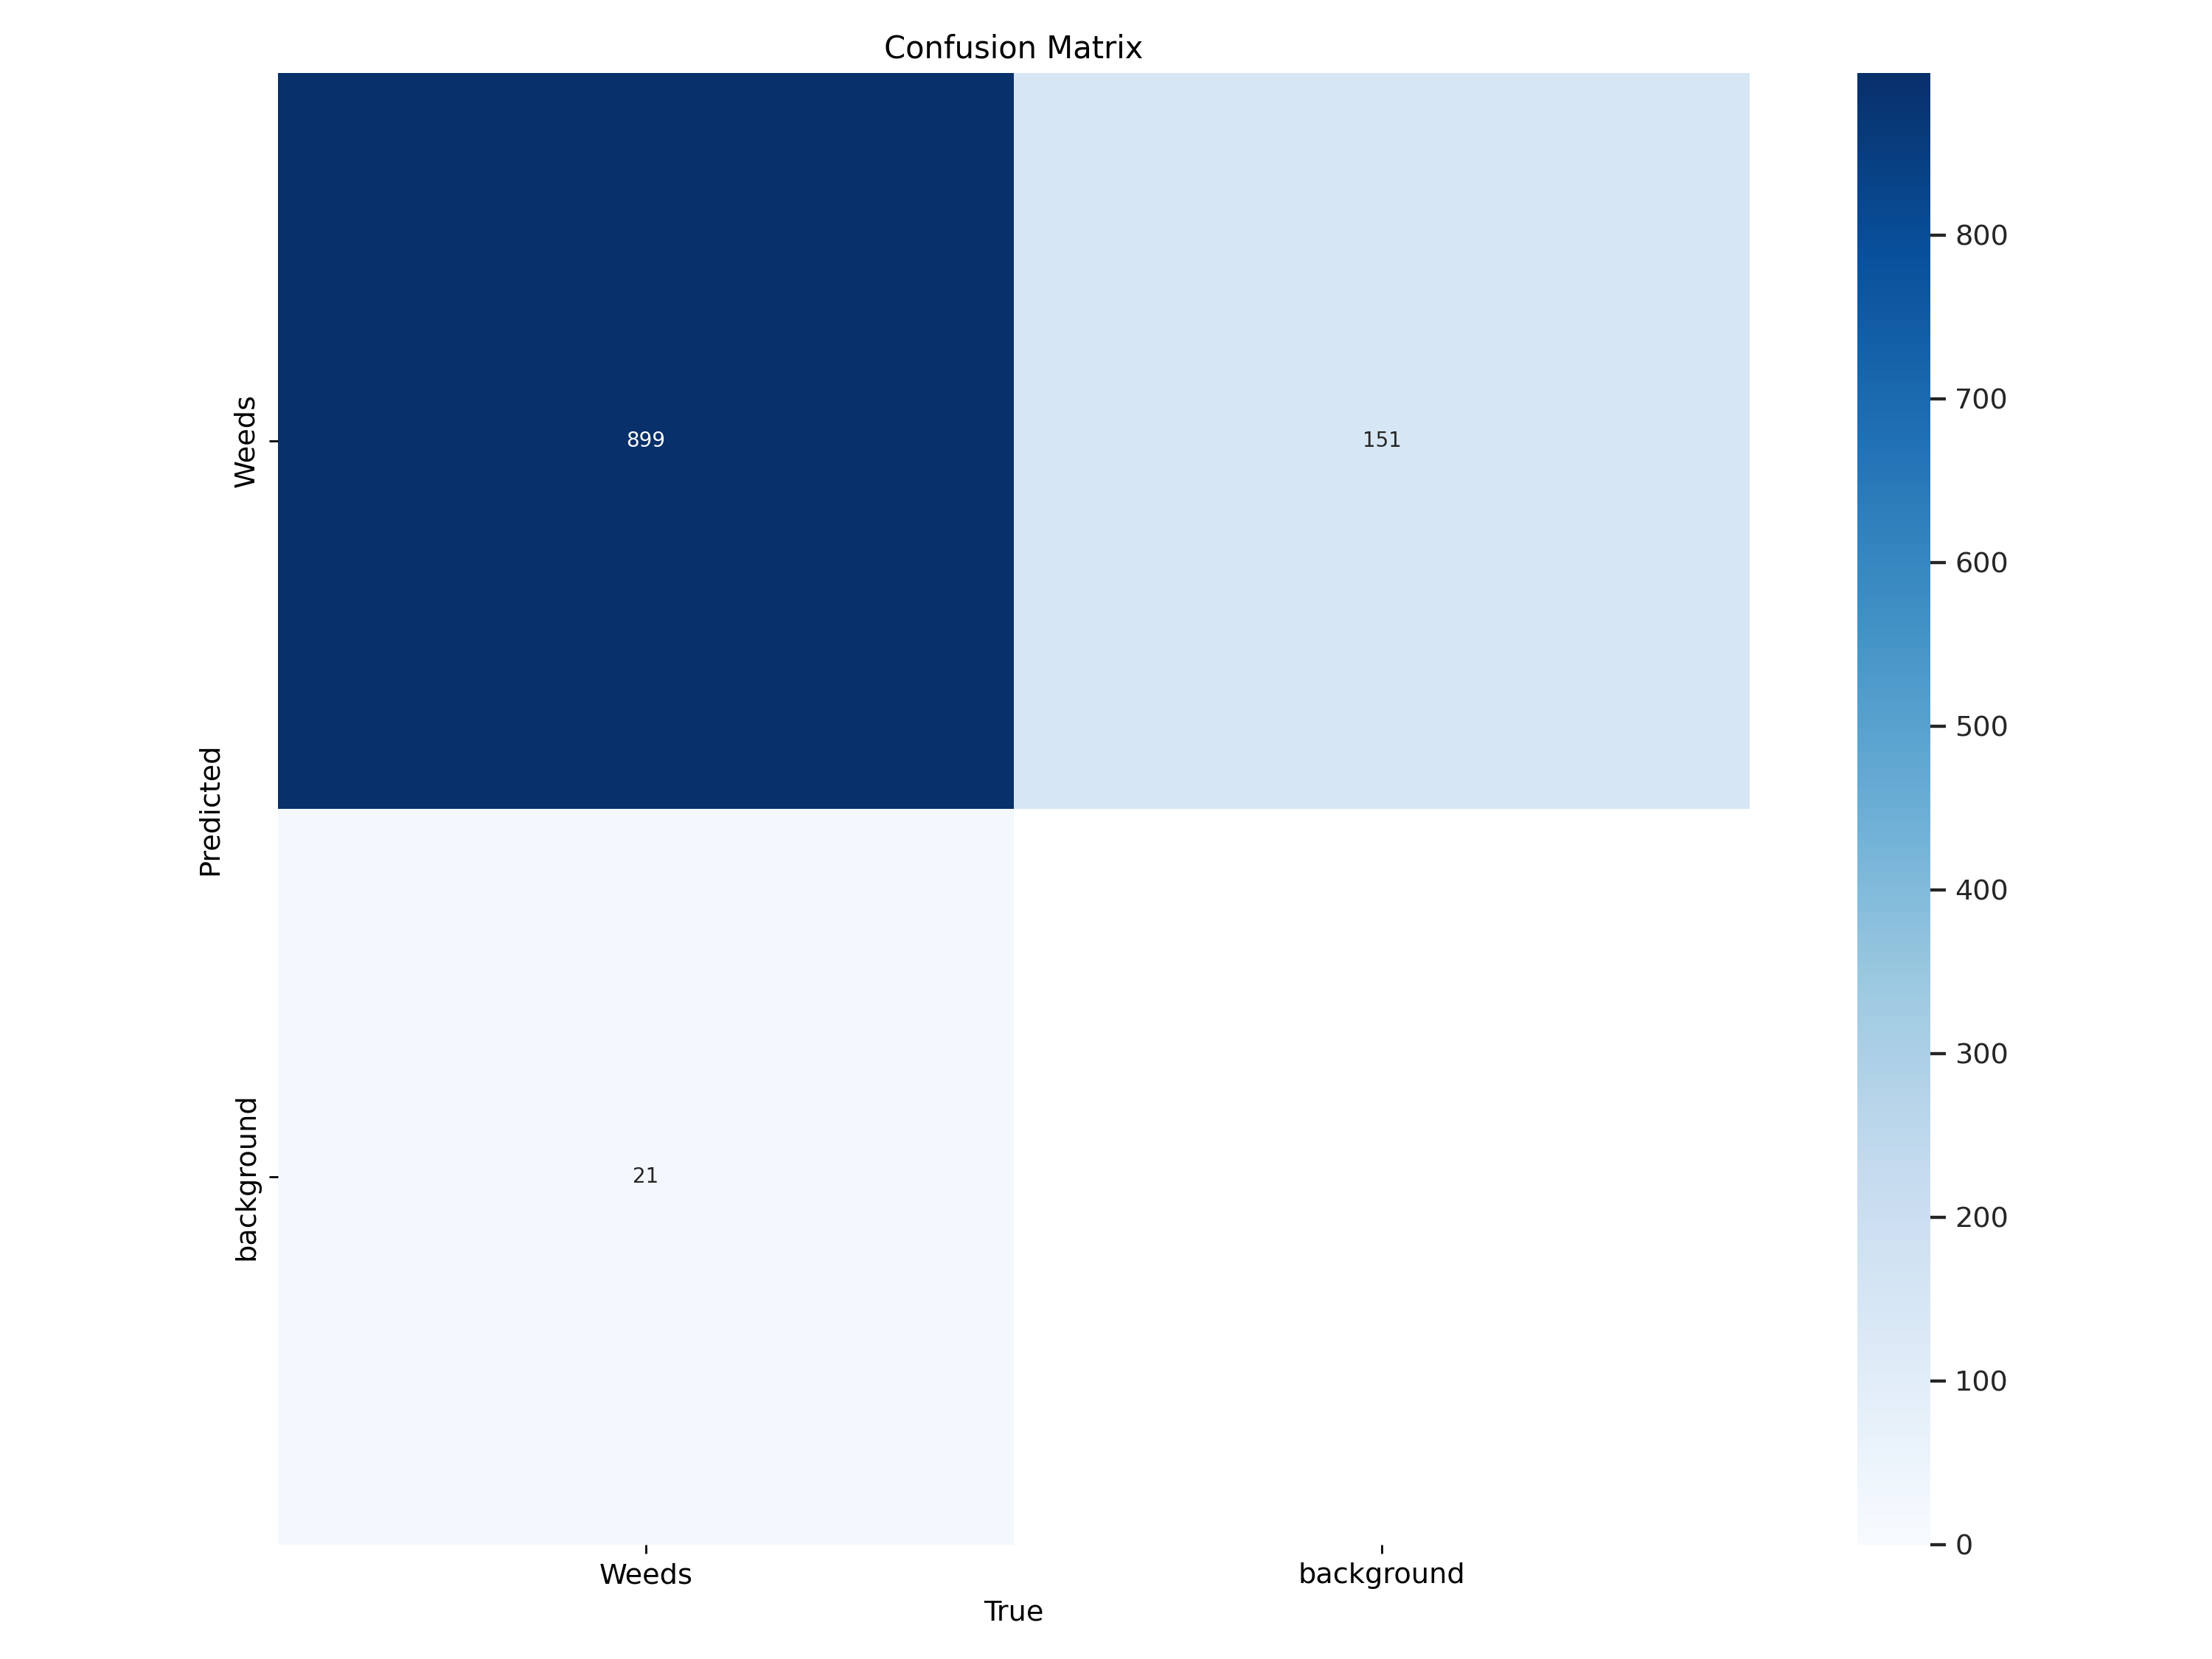

In [20]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

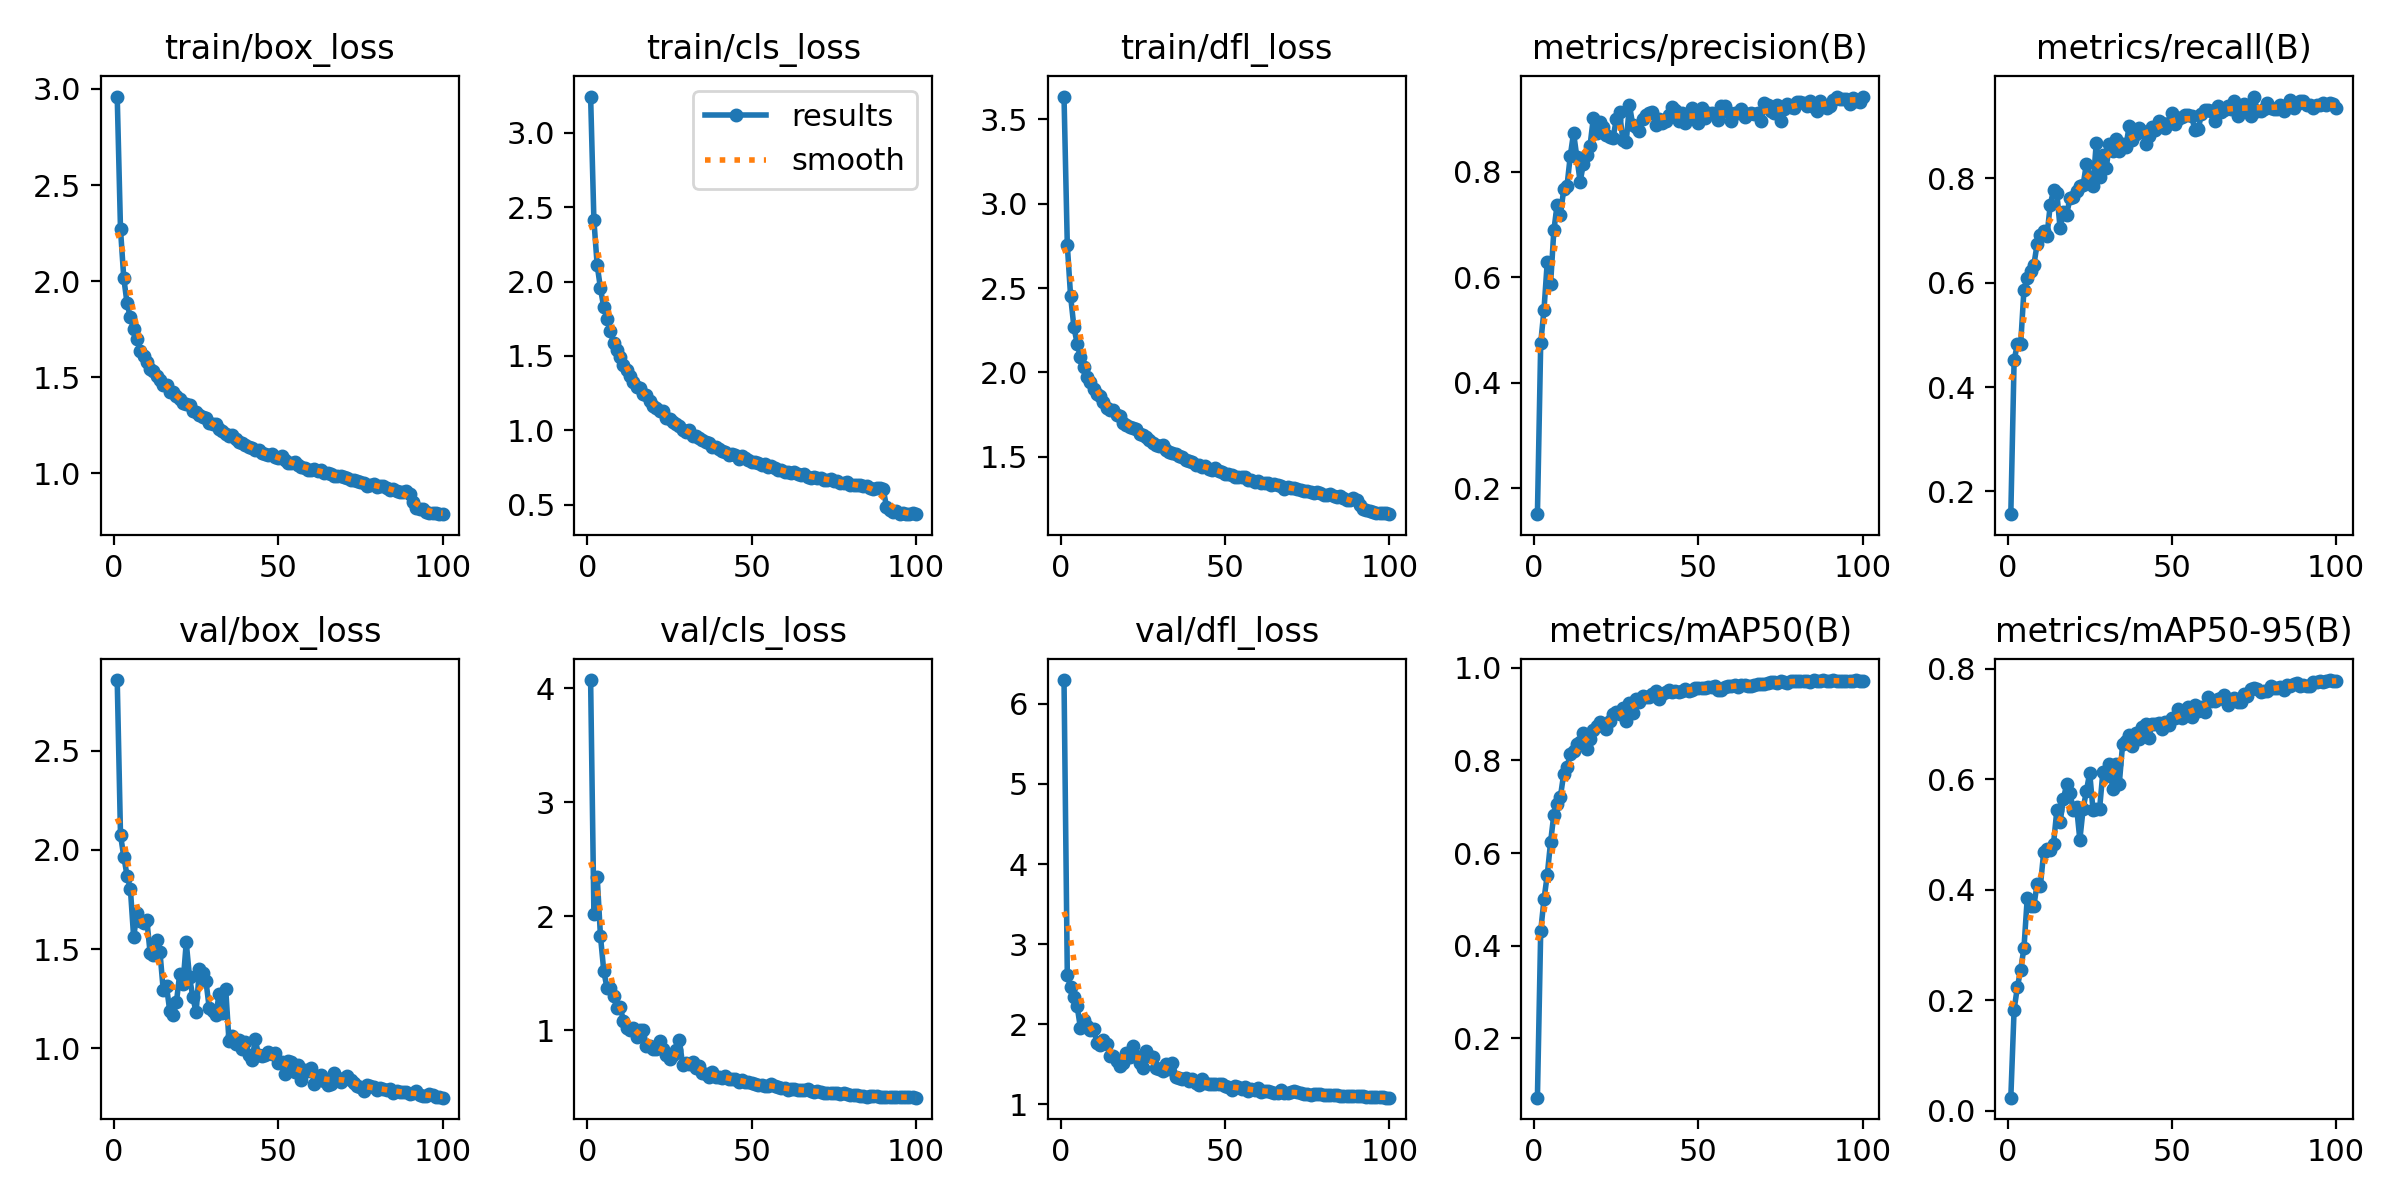

In [21]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [22]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['Weeds']

In [23]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [24]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.6545918168886763
mAP 50 0.9568390897309107
mAP 75 0.8199609020139853


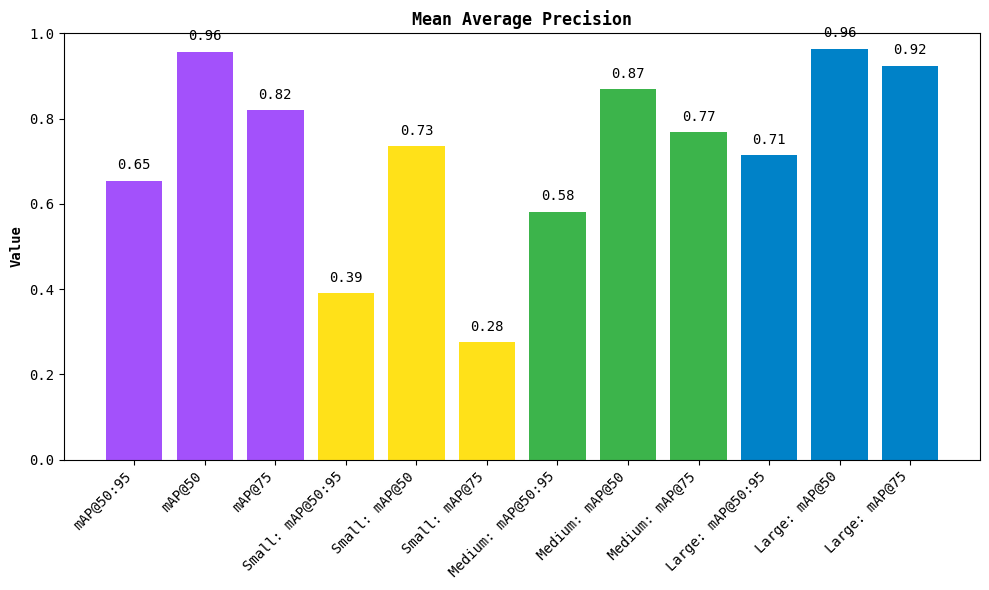

In [25]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [18]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

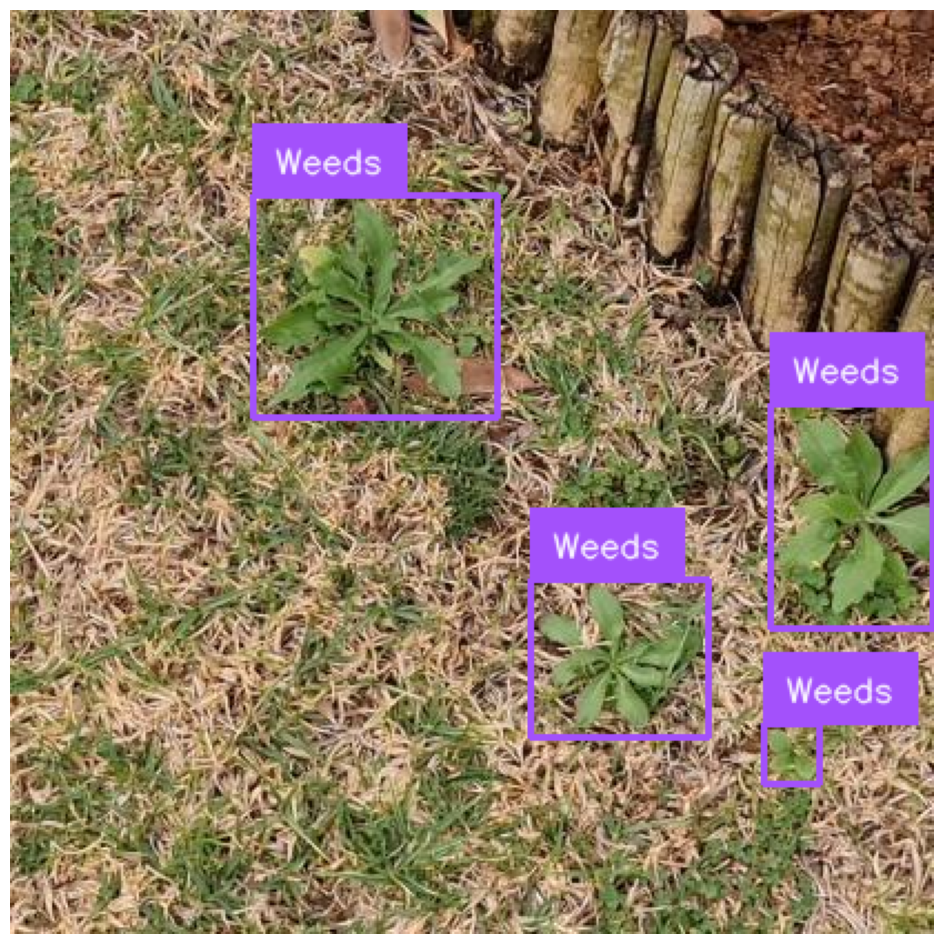

In [19]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)